In [1]:
import re
import json
import pickle
from string import punctuation

import nltk
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras import layers
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

2023-01-08 10:37:14.851878: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-08 10:37:15.625583: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-08 10:37:15.625611: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-08 10:37:18.535255: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
def plot_hisory(history_dict: dict):
    plt.plot(history_dict['accuracy'])
    plt.plot(history_dict['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [3]:
def get_model_checkpoint_callback(filepath):
    return ModelCheckpoint(
        filepath,
        save_best_only=True,
        monitor='val_accuracy',
        verbose=1
    )

## Processing

In [4]:
NUMBER_OF_WORDS_TO_TOKENIZE = 20_000

emoji_regex_compiled = re.compile(
    "["
    u"\U0001F600-\U0001F64F"  # emoticons
    u"\U0001F300-\U0001F5FF"  # symbols & pictographs
    u"\U0001F680-\U0001F6FF"  # transport & map symbols
    u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
    u"\U00002500-\U00002BEF"  # chinese char
    u"\U00002702-\U000027B0"
    u"\U00002702-\U000027B0"
    u"\U000024C2-\U0001F251"
    u"\U0001f926-\U0001f937"
    u"\U00010000-\U0010ffff"
    u"\u2640-\u2642"
    u"\u2600-\u2B55"
    u"\u200d"
    u"\u23cf"
    u"\u23e9"
    u"\u231a"
    u"\ufe0f"  # dingbats
    u"\u3030"
    "]+",
    re.UNICODE
)

MAX_POST_LEN_IN_WORDS = 20

with open("./config/RUSSIAN_STOP_WORDS.json") as stop_words_file:
    stop_words = json.load(stop_words_file)

In [5]:
def clean_text(text: str) -> str:
    text = re.sub(r'[0-9]', '', text)
    text = re.sub(r'<[^>]+>', ' ', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(emoji_regex_compiled, '', text)

    cleared_words = [word for word in nltk.word_tokenize(text) if word.isalpha() and word not in stop_words]
    truncated_text = cleared_words[:MAX_POST_LEN_IN_WORDS]
    text = ' '.join(truncated_text)

    text = re.sub(rf'[{punctuation}]', '', text)
    text = text.replace(' – ', ' ').replace(' - ', ' ').replace(' — ', ' ')
    text = text.replace('»', '').replace('«', '')

    text = re.sub(' +', ' ', text)

    return text

In [6]:
df = pd.read_csv(
    './data/training-data/init-news.csv',
    names=['channel', 'text', 'date', 'type', 'sent']
)

df = df[~df['text'].isna()]
df['text'] = df['text'].apply(clean_text)

In [7]:
df.head()

,channel,text,date,type,sent
0,раньше всех. ну почти.,президент эстонии алар карис признал удастся п...,2022-05-17 18:20:01,Economical,-1
1,раньше всех. ну почти.,россияне февраля стали тратить раза новости ин...,2022-05-17 18:11:38,Political,-1
2,раньше всех. ну почти.,суд приговорил эксполковника захарченко совоку...,2022-05-17 17:53:12,Shelling,-1
3,раньше всех. ну почти.,евросоюз допустит украине закончилось оружие в...,2022-05-17 17:44:46,Political,-1
4,раньше всех. ну почти.,сша активно привлекают участия боевых действия...,2022-05-17 17:43:05,Political,-1


In [8]:
df['type'].value_counts()

Political       581
Shelling        377
Economical      339
Humanitarian    271
Name: type, dtype: int64

In [9]:
tokenizer = Tokenizer(num_words=NUMBER_OF_WORDS_TO_TOKENIZE)
tokenizer.fit_on_texts(df['text'])

In [10]:
pickle.dump(tokenizer, open('./trained-models/keras-tokenizer.pk', 'wb'))

In [13]:
text_sequences = pad_sequences(tokenizer.texts_to_sequences(df['text']), maxlen=MAX_POST_LEN_IN_WORDS, padding='pre', truncating='post')

In [14]:
df['type'] = pd.factorize(df['type'])[0]

In [15]:
categorical_types = to_categorical(df['type'])

In [16]:
x_train, x_test, y_train, y_test = train_test_split(
    text_sequences,
    categorical_types,
    test_size=0.2
)

# Building a LSTM model

In [17]:
lstm_model = Sequential([
    layers.Embedding(NUMBER_OF_WORDS_TO_TOKENIZE, 16, input_length=MAX_POST_LEN_IN_WORDS),
    layers.LSTM(32, recurrent_dropout=0.2),
    layers.Dense(4, activation='softmax')
])

2023-01-08 10:38:06.350595: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-01-08 10:38:06.351006: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-08 10:38:06.351035: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (kinfi4-laptop): /proc/driver/nvidia/version does not exist
2023-01-08 10:38:06.351873: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
lstm_model.compile('adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
save_callback = get_model_checkpoint_callback('./trained-models/lstm-news-type-prediction.h5')
history = lstm_model.fit(
    x=x_train,
    y=y_train,
    epochs=15,
    batch_size=32,
    validation_split=0.1,
    callbacks=[save_callback]
)

Epoch 1/15
36/36 [==============================] - ETA: 0s - loss: 1.3648 - accuracy: 0.3661
Epoch 1: val_accuracy improved from -inf to 0.36508, saving model to ./trained-models/lstm-news-type-prediction.h5
36/36 [==============================] - 4s 32ms/step - loss: 1.3648 - accuracy: 0.3661 - val_loss: 1.3431 - val_accuracy: 0.3651
Epoch 2/15
34/36 [===========================>..] - ETA: 0s - loss: 1.2984 - accuracy: 0.3686
Epoch 2: val_accuracy improved from 0.36508 to 0.41270, saving model to ./trained-models/lstm-news-type-prediction.h5
36/36 [==============================] - 1s 19ms/step - loss: 1.2975 - accuracy: 0.3697 - val_loss: 1.2685 - val_accuracy: 0.4127
Epoch 3/15
34/36 [===========================>..] - ETA: 0s - loss: 1.0512 - accuracy: 0.5037
Epoch 3: val_accuracy improved from 0.41270 to 0.46032, saving model to ./trained-models/lstm-news-type-prediction.h5
36/36 [==============================] - 1s 18ms/step - loss: 1.0550 - accuracy: 0.5044 - val_loss: 1.2452 

In [20]:
score = lstm_model.evaluate(x_test, y_test, verbose=0)

print(f'The accuracy of the model = {round(score[1], 3)}')

The accuracy of the model = 0.697


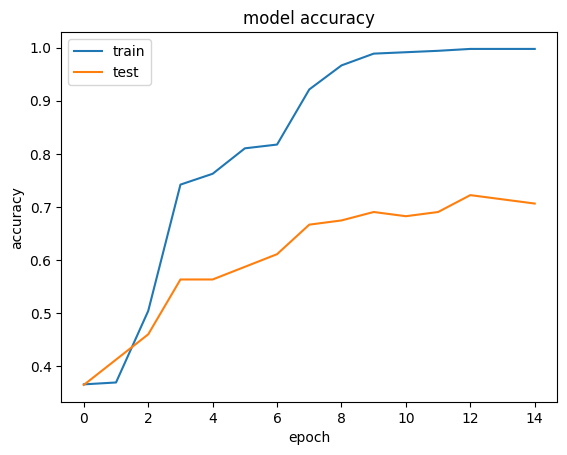

In [21]:
plot_hisory(history.history)

# Building CNN model

In [22]:
cnn_model = Sequential([
    layers.Embedding(NUMBER_OF_WORDS_TO_TOKENIZE, 8, input_length=MAX_POST_LEN_IN_WORDS),
    layers.Conv1D(250, 4, activation='relu', padding='same'),
    layers.GlobalMaxPool1D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(4, activation='softmax')
])

In [23]:
cnn_model.compile('adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
save_callback = get_model_checkpoint_callback('./trained-models/cnn-news-type-prediction.h5')
history = cnn_model.fit(
    x=x_train,
    y=y_train,
    epochs=15,
    batch_size=32,
    validation_split=0.1,
    callbacks=[save_callback]
)

Epoch 1/15
31/36 [========================>.....] - ETA: 0s - loss: 1.3459 - accuracy: 0.3760
Epoch 1: val_accuracy improved from -inf to 0.36508, saving model to ./trained-models/cnn-news-type-prediction.h5
36/36 [==============================] - 2s 13ms/step - loss: 1.3486 - accuracy: 0.3688 - val_loss: 1.3303 - val_accuracy: 0.3651
Epoch 2/15
30/36 [========================>.....] - ETA: 0s - loss: 1.2966 - accuracy: 0.3698
Epoch 2: val_accuracy did not improve from 0.36508
36/36 [==============================] - 0s 6ms/step - loss: 1.2958 - accuracy: 0.3688 - val_loss: 1.2848 - val_accuracy: 0.3651
Epoch 3/15
36/36 [==============================] - ETA: 0s - loss: 1.1468 - accuracy: 0.4158
Epoch 3: val_accuracy improved from 0.36508 to 0.50000, saving model to ./trained-models/cnn-news-type-prediction.h5
36/36 [==============================] - 0s 9ms/step - loss: 1.1468 - accuracy: 0.4158 - val_loss: 1.2016 - val_accuracy: 0.5000
Epoch 4/15
29/36 [=======================>......

In [25]:
score = cnn_model.evaluate(x_test, y_test, verbose=0)

print(f'The accuracy of the model = {round(score[1], 3)}')

The accuracy of the model = 0.672


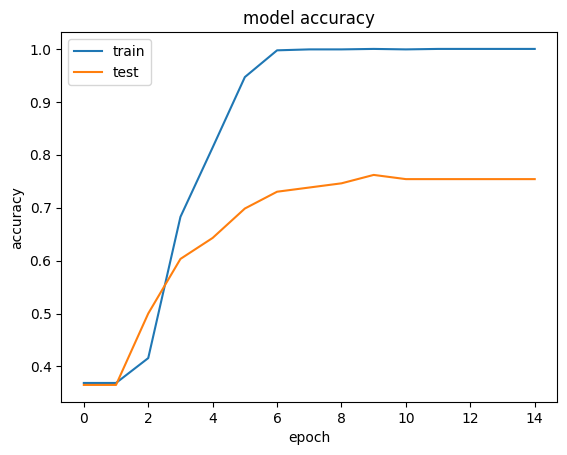

In [26]:
plot_hisory(history.history)